In [5]:
import numpy as np
import numpy.testing as npt
import xarray as xr
import xrft
import numpy.fft as npft
import scipy.signal as signal
import dask.array as dsar
import matplotlib.pyplot as plt
%matplotlib inline

Taken from xrft documentation (https://xrft.readthedocs.io/en/latest/DFT-iDFT_example.html).
In this notebook, we provide examples of the discrete Fourier transform (DFT) and its inverse, and how xrft automatically harnesses the metadata. We compare the results to conventional numpy.fft to highlight the strengths of xrft.

### Generate synthetic data centered around zero

In [6]:
k0 = 1/0.52
T = 4.
dx = 0.02
x = np.arange(-2*T,2*T,dx) #Define time array
y = np.cos(2*np.pi*k0*x)   #Define wave time series
y[np.abs(x)>T/2]=0.        #Zero out the signal except for -2<T<2
da = xr.DataArray(y, dims=('x',), coords={'x':x}) #Convert to an xarray dataset

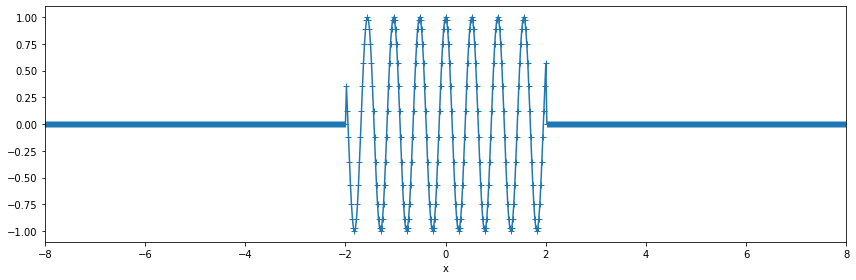

In [7]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
da.plot(ax=ax, marker='+', label='original signal')
ax.set_xlim([-8,8]);

In [115]:
#Computing my own version of the FFT and power spectrum using numpy:

PS  = (np.abs(np.fft.fft(da))**2)
freq= np.fft.fftfreq(da.size,dx) #fft is just twice as long as rfft since it includes imaginary part
#idx=np.argsort(freq)
#Normalize:
PS=PS/(800**2)

PSXRFT=xrft.power_spectrum(da).compute()
print(PSXRFT)

<xarray.DataArray (freq_x: 800)>
array([2.49641794e-07, 4.15295306e-06, 8.06795136e-06, 4.17612065e-06,
       2.49766840e-07, 4.13194930e-06, 8.07205249e-06, 4.20149888e-06,
       2.50142420e-07, 4.11306714e-06, 8.08026323e-06, 4.22913943e-06,
       2.50769856e-07, 4.09626880e-06, 8.09260052e-06, 4.25909901e-06,
       2.51651368e-07, 4.08152078e-06, 8.10908991e-06, 4.29143961e-06,
       2.52790081e-07, 4.06879372e-06, 8.12976560e-06, 4.32622882e-06,
       2.54190049e-07, 4.05806226e-06, 8.15467067e-06, 4.36354011e-06,
       2.55856287e-07, 4.04930494e-06, 8.18385721e-06, 4.40345316e-06,
       2.57794798e-07, 4.04250412e-06, 8.21738659e-06, 4.44605426e-06,
       2.60012621e-07, 4.03764588e-06, 8.25532974e-06, 4.49143666e-06,
       2.62517881e-07, 4.03471999e-06, 8.29776745e-06, 4.53970110e-06,
       2.65319840e-07, 4.03371984e-06, 8.34479078e-06, 4.59095623e-06,
       2.68428973e-07, 4.03464241e-06, 8.39650147e-06, 4.64531920e-06,
       2.71857036e-07, 4.03748825e-06, 8.453

In [116]:
len(freq)

800

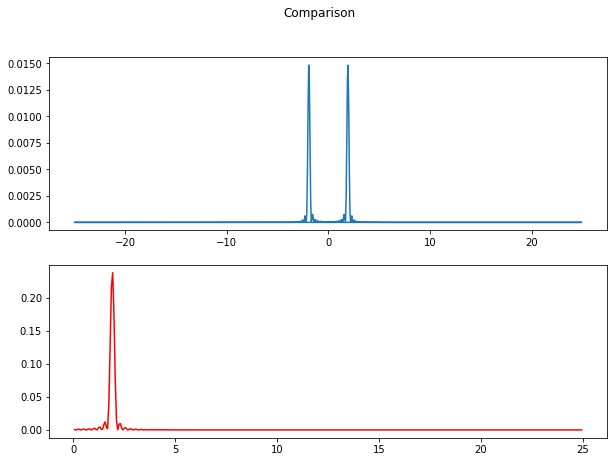

In [117]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(10,7))
fig.suptitle('Comparison')
ax1.plot(freq, PS)
ax2.plot(PSXRFT.freq_x[401:], PSXRFT[401:],'r')

### We will compare the Fourier transform with and without taking into consideration about the phase information.

In [14]:
da_dft = xrft.dft(da, true_phase=True, true_amplitude=True) # Fourier Transform w/ consideration of phase
da_fft = xrft.fft(da)                                       # Fourier Transform w/ numpy.fft-like behavior
da_npft = npft.fft(da)                                      # Using numpy FFT
#print(da_dft,da_fft,da_npft)
print(da_dft)

<xarray.DataArray (freq_x: 800)>
array([ 1.99856666e-03-5.35327021e-14j,  1.38120880e-03-8.03364869e-03j,
       -9.05489114e-05-1.13612949e-02j, -1.50944329e-03-8.03364869e-03j,
       -1.99906714e-03+5.24047026e-14j, -1.25366563e-03+8.03364869e-03j,
        2.71693405e-04+1.13612949e-02j,  1.63843549e-03+8.03364869e-03j,
        2.00056960e-03-5.14010876e-14j,  1.12674883e-03-8.03364869e-03j,
       -4.52978013e-04-1.13612949e-02j, -1.76825328e-03-8.03364869e-03j,
       -2.00307706e-03+5.04188513e-14j, -1.00039467e-03+8.03364869e-03j,
        6.34496470e-04+1.13612949e-02j,  1.89896624e-03+8.03364869e-03j,
        2.00659460e-03-4.95145722e-14j,  8.74540590e-04-8.03364869e-03j,
       -8.16343007e-04-1.13612949e-02j, -2.03064581e-03-8.03364869e-03j,
       -2.01112936e-03+4.85826877e-14j, -7.49125002e-04+8.03364869e-03j,
        9.98612548e-04+1.13612949e-02j,  2.16336539e-03+8.03364869e-03j,
        2.01669055e-03-4.75353786e-14j,  6.24087223e-04-8.03364869e-03j,
       -1.18140091

In [15]:
k = da_dft.freq_x # wavenumber axis
TF_s = (T/2)*(np.sinc(T*(k-k0)) + np.sinc(T*(k+k0))) # Theoretical result of the Fourier transform
#print(TF_s)

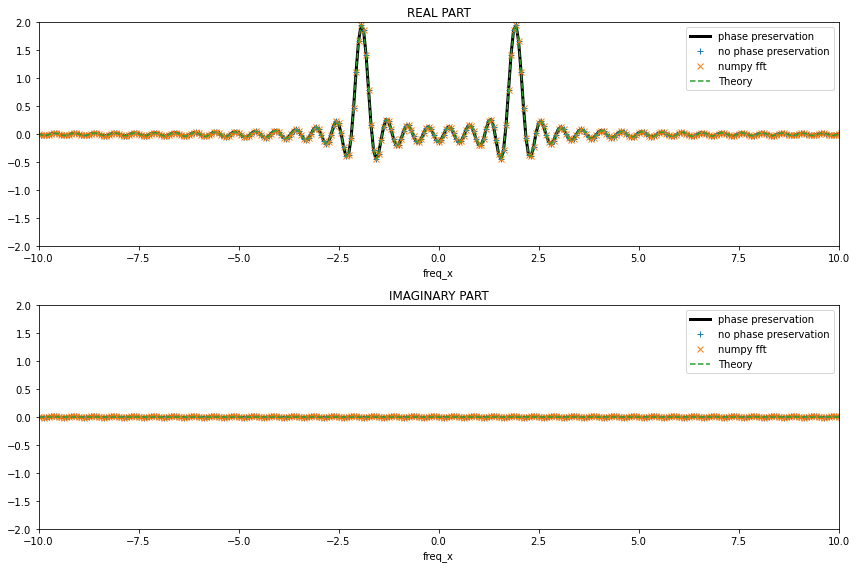

In [16]:
r = (-1)**np.arange(0,len(y))

fig, (ax1,ax2) = plt.subplots(figsize=(12,8), nrows=2, ncols=1)
fig.set_tight_layout(True)

(da_dft.real).plot(ax=ax1, linestyle='-', lw=3, c='k', label='phase preservation')
(r*(da_fft*dx).real).plot(ax=ax1, linestyle='', marker='+',label='no phase preservation')
ax1.plot(k, r*(npft.fftshift(da_npft)*dx).real, linestyle='', marker='x',label='numpy fft')
ax1.plot(k, TF_s.real, linestyle='--', label='Theory')
ax1.set_xlim([-10,10])
#ax1.set_xlim([-2.5,2.5])
ax1.set_ylim([-2,2])
ax1.legend()
ax1.set_title('REAL PART')

(da_dft.imag).plot(ax=ax2, linestyle='-', lw=3, c='k', label='phase preservation')
(r*(da_fft*dx).imag).plot(ax=ax2, linestyle='', marker='+', label='no phase preservation')
ax2.plot(k, r*(npft.fftshift(da_npft)*dx).imag, linestyle='', marker='x',label='numpy fft')
ax2.plot(k, TF_s.imag, linestyle='--', label='Theory')
ax2.set_xlim([-10,10])
ax2.set_ylim([-2,2])
ax2.legend()
ax2.set_title('IMAGINARY PART');

### xrft.dft and xrft.fft (and numpy.fft) all give the same results as theory (as the coordinates of the original data was centered).

### Now perform the inverse transform:

In [17]:
ida_dft = xrft.idft(da_dft, true_phase=True, true_amplitude=True) # Signal in direct space
ida_fft = xrft.ifft(da_fft)

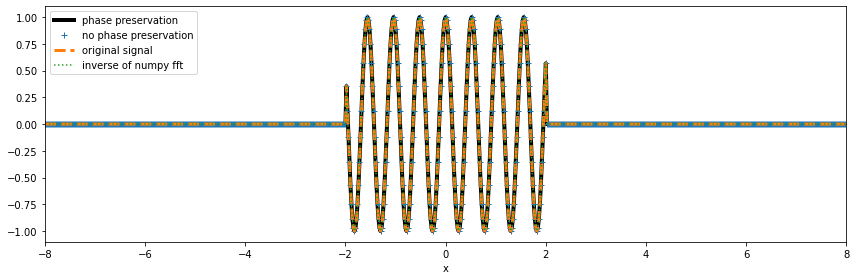

In [18]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
ida_dft.real.plot(ax=ax, linestyle='-', c='k', lw=4, label='phase preservation')
ax.plot(x, ida_fft.real, linestyle='', marker='+', label='no phase preservation') # w/out the phase information, the coordinates are lost
da.plot(ax=ax, ls='--', lw=3, label='original signal')
ax.plot(x, npft.ifft(da_npft).real, ls=':', label='inverse of numpy fft')
ax.set_xlim([-8,8])
ax.legend(loc='upper left');

#### Now let’s shift the coordinates so that they are not centered.

#### This is where the ``xrft`` magic happens. With the relevant flags, xrft’s dft can preserve information about the data’s location in its original space. This information is not preserved in a numpy fourier transform. This section demonstrates how to preserve this information using the true_phase=True, true_amplitude=True flags.

In [9]:
nshift = 70                          # defining a shift
x0 = dx*nshift
nda = da.shift(x=nshift).dropna('x')

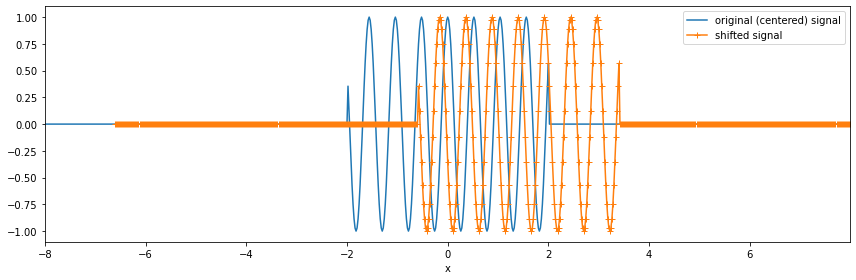

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
da.plot(ax=ax, label='original (centered) signal')
nda.plot(ax=ax, marker='+', label='shifted signal')
ax.set_xlim([-8,nda.x.max()])
ax.legend();

In [11]:
nda_dft = xrft.dft(nda, true_phase=True, true_amplitude=True) # Fourier Transform w/ phase preservation
nda_fft = xrft.fft(nda)                                       # Fourier Transform w/out phase preservation
nda_npft = npft.fft(nda)                                      # Numpy Fourier Transform


In [32]:
nk = nda_dft.freq_x # wavenumber axis
TF_ns = (T/2)*(np.sinc(T*(nk-k0)) + np.sinc(T*(nk+k0)))*np.exp(-2j*np.pi*nk*x0) # Theoretical FT (Note the additional phase)

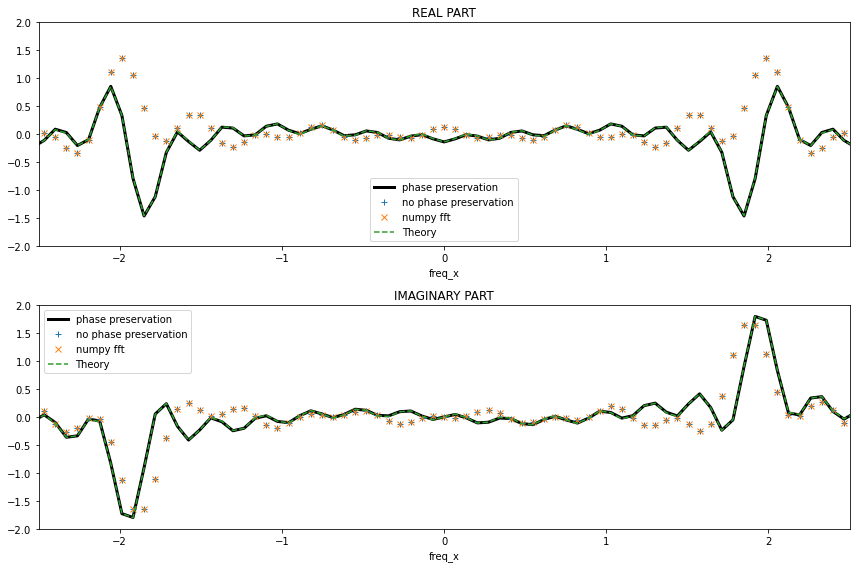

In [33]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,8), nrows=2, ncols=1)
fig.set_tight_layout(True)

(nda_dft.real).plot(ax=ax1, linestyle='-', lw=3, c='k', label='phase preservation')
(r[nshift:]*(nda_fft*dx).real).plot(ax=ax1, linestyle='', marker='+',label='no phase preservation')
ax1.plot(nk, r[nshift:]*(npft.fftshift(nda_npft)*dx).real, linestyle='', marker='x',label='numpy fft')
ax1.plot(nk, TF_ns.real, linestyle='--', label='Theory')
#ax1.set_xlim([-10,10])
ax1.set_xlim([-2.5,2.5])
ax1.set_ylim([-2.,2])
ax1.legend()
ax1.set_title('REAL PART')

(nda_dft.imag).plot(ax=ax2, linestyle='-', lw=3, c='k', label='phase preservation')
(r[nshift:]*(nda_fft*dx).imag).plot(ax=ax2, linestyle='', marker='+', label='no phase preservation')
ax2.plot(nk, r[nshift:]*(npft.fftshift(nda_npft)*dx).imag, linestyle='', marker='x',label='numpy fft')
ax2.plot(nk, TF_ns.imag, linestyle='--', label='Theory')
#ax2.set_xlim([-10,10])
ax2.set_xlim([-2.5,2.5])
ax2.set_ylim([-2.,2.])
ax2.legend()
ax2.set_title('IMAGINARY PART');

### Now taking the inverse transform again:

In [47]:
inda_dft = xrft.idft(nda_dft, true_phase=True, true_amplitude=True) # Signal in direct space
inda_fft = xrft.ifft(nda_fft)

In [48]:
nda_fft.shape

(730,)

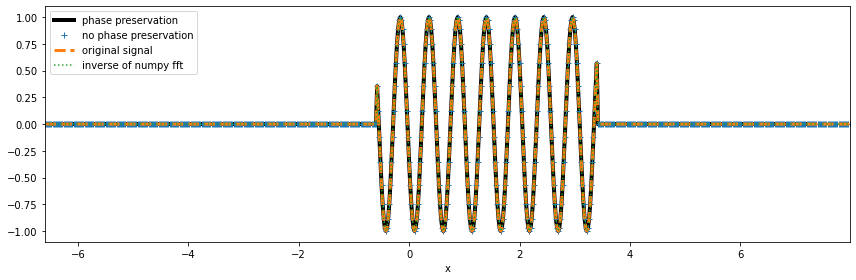

In [49]:

fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
inda_dft.real.plot(ax=ax, linestyle='-', c='k', lw=4, label='phase preservation')
ax.plot(x[nshift:], inda_fft.real, linestyle='', marker='+', label='no phase preservation')
nda.plot(ax=ax, ls='--', lw=3, label='original signal')
ax.plot(x[nshift:], npft.ifft(nda_npft).real, ls=':', label='inverse of numpy fft')
ax.set_xlim([nda.x.min(),nda.x.max()])
ax.legend(loc='upper left');

Note that we are only able to match the inverse transforms of xrft.ifft and numpy.ifft to the data nda to it being Fourier transformed because we “know” the original data da was shifted by nshift datapoints as we see in x[nshift:]. Using ``xrft.idft`` along with ``xrft.dft`` with the flags ``true_phase=True`` and ``true_amplitude=True`` automatically takes care of the information of shifted coordinates.